# Reference：https://github.com/mc6666/PyTorch_Book/blob/main/src_cn/12_07_LSTM_Time_Series.ipynb

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext

In [2]:
## 確認 GPU 存不存在
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
## 載入資料
import pandas as pd

data = pd.read_csv('airline-passengers.csv')
data

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


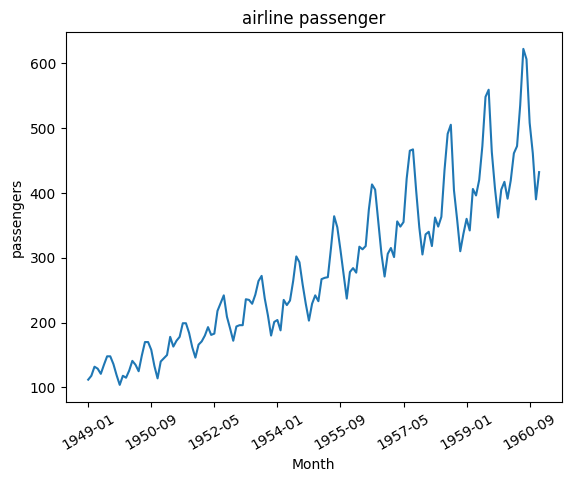

In [4]:
## 繪圖
import matplotlib.pyplot as plt
data1 = data.set_index('Month')

data1.plot(legend=None)
plt.xticks(rotation=30)
plt.ylabel('passengers')
plt.title('airline passenger')
plt.show()

In [5]:
data

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [6]:
## 轉換資料
import numpy as np
look_back = 1  # 以前N期資料為 x 預測當期 y

def create_dataset(data, look_back):
  x = []
  y = []
  for i in range(len(data)-look_back):
    x.append(data[i:(i+look_back)])
    y.append(data[i+look_back])

  return torch.tensor(np.array(x)).to(device), torch.tensor(np.array(y)).to(device)

dataset = data1[['Passengers']].values.astype('float32')
dataset

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.],
       [135.],
       [148.],
       [148.],
       [136.],
       [119.],
       [104.],
       [118.],
       [115.],
       [126.],
       [141.],
       [135.],
       [125.],
       [149.],
       [170.],
       [170.],
       [158.],
       [133.],
       [114.],
       [140.],
       [145.],
       [150.],
       [178.],
       [163.],
       [172.],
       [178.],
       [199.],
       [199.],
       [184.],
       [162.],
       [146.],
       [166.],
       [171.],
       [180.],
       [193.],
       [181.],
       [183.],
       [218.],
       [230.],
       [242.],
       [209.],
       [191.],
       [172.],
       [194.],
       [196.],
       [196.],
       [236.],
       [235.],
       [229.],
       [243.],
       [264.],
       [272.],
       [237.],
       [211.],
       [180.],
       [201.],
       [204.],
       [188.],
       [235.],
       [227.],
       [234.],
       [264.],
       [30

In [7]:
## 將 X 縮放到 0 和 1 之間(歸一化)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)
dataset

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984557],
       [0.08494207],
       [0.08494207],
       [0.06177607],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123553],
       [0.04247104],
       [0.07142857],
       [0.05984557],
       [0.04054055],
       [0.08687258],
       [0.12741312],
       [0.12741312],
       [0.10424709],
       [0.05598456],
       [0.01930502],
       [0.06949806],
       [0.07915059],
       [0.08880308],
       [0.14285713],
       [0.11389962],
       [0.13127413],
       [0.14285713],
       [0.18339768],
       [0.18339768],
       [0.15444016],
       [0.11196911],
       [0.08108109],
       [0.1196911 ],
       [0.12934363],
       [0.14671814],
       [0.17181468],
       [0.14864865],
       [0.15250966],
       [0.22007722],
       [0.24324325],
       [0.26640925],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

In [8]:
## 資料分割
train_size = int(len(dataset)*0.67)  # 資料的 2/3 為 train_data
test_size = len(dataset) - train_size

train_data = dataset[0:train_size, :]
test_data = dataset[train_size:len(dataset):, :]

train_x, train_y = create_dataset(train_data, look_back)
test_x, test_y = create_dataset(test_data, look_back)

In [9]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

(torch.Size([95, 1, 1]),
 torch.Size([95, 1]),
 torch.Size([47, 1, 1]),
 torch.Size([47, 1]))

In [10]:
## 建立模型
class TimeSeriesModel(nn.Module):
    def __init__(self, look_back, hidden_size=4, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size # 神經元個數
        self.num_layers = num_layers  #隱藏層層數
        # batch_first = True 輸出資料批量移至第一維，但 h_out 和 _c_out 不變
        self.lstm = nn.LSTM(1, self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, x):
        # print(x.shape)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, (h_out, _) = self.lstm(x, (h_0, c_0))
        # print(h_out.shape)

        # 取最後一層的 h，並轉成二维
        h_out = h_out[-1].view(-1, self.hidden_size)  # (95, 4)
        return self.fc(h_out)

model = TimeSeriesModel(look_back, hidden_size=4, num_layers=1).to(device)

In [11]:
epoches = 2000
learning_rate = 0.01

def train(train_x, train_y):
    criterion = torch.nn.MSELoss()  # MSE
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epoches):
        optimizer.zero_grad()
        outputs = model(train_x)
        if epoch <= 0: print(outputs.shape)
        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, loss: {loss.item():.5f}")

train(train_x, train_y)

torch.Size([95, 1])
Epoch: 0, loss: 0.05098
Epoch: 100, loss: 0.00194
Epoch: 200, loss: 0.00193
Epoch: 300, loss: 0.00192
Epoch: 400, loss: 0.00192
Epoch: 500, loss: 0.00192
Epoch: 600, loss: 0.00192
Epoch: 700, loss: 0.00192
Epoch: 800, loss: 0.00192
Epoch: 900, loss: 0.00192
Epoch: 1000, loss: 0.00192
Epoch: 1100, loss: 0.00192
Epoch: 1200, loss: 0.00192
Epoch: 1300, loss: 0.00192
Epoch: 1400, loss: 0.00192
Epoch: 1500, loss: 0.00192
Epoch: 1600, loss: 0.00192
Epoch: 1700, loss: 0.00192
Epoch: 1800, loss: 0.00192
Epoch: 1900, loss: 0.00192


In [12]:
## 評估模型
model.eval()
trainPredict = model(train_x).detach().numpy()  # 只需張量的值，不希望這些操作被記錄在計算圖中，故使用 detach()
testPredict = model(test_x).detach().numpy()

In [13]:
from sklearn.metrics import mean_squared_error
import math

# 將資料還原成歸一化前
trainPredict = scaler.inverse_transform(trainPredict)  # inverse_transform：將縮放後的數據還原成原始範圍
trainY_actual = scaler.inverse_transform(train_y)
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(test_y)
print(trainY_actual.shape, trainPredict.shape)

# 計算 RMSE
trainScore = math.sqrt(mean_squared_error(trainY_actual.reshape(-1), trainPredict.reshape(-1)))
print(f'Train RMSE: {trainScore:.2f}')
testScore = math.sqrt(mean_squared_error(testY_actual.reshape(-1), testPredict.reshape(-1)))
print(f'Test RMSE:  {testScore:.2f}')

(95, 1) (95, 1)
Train RMSE: 22.70
Test RMSE:  57.59


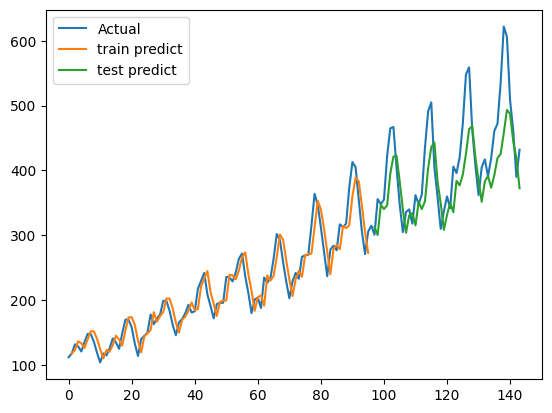

In [14]:
## 繪製圖表
# 訓練資料的 X 和 Y
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+1, :] = trainPredict

# 測試資料的 X 和 Y
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[-testPredict.shape[0]:, :] = testPredict

# 繪圖
plt.plot(scaler.inverse_transform(dataset), label='Actual')
plt.plot(trainPredictPlot, label='train predict')
plt.plot(testPredictPlot, label='test predict')
plt.legend()
plt.show()